In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

df = pd.read_csv("instances.csv")
df.head()

,instance_id,repo,base_commit,split,model,input_tokens,output_tokens,num_requests,price,total_changes,files_changed,additions,deletions,solved
0,sympy__sympy-16792,sympy/sympy,09786a173e7a0a488f46dd6000177c23e5d24eed,test,claude-3.7,1300000.0,9600.0,17.0,2.6601,21.0,2.0,20.0,1.0,1
1,sympy__sympy-16792,sympy/sympy,09786a173e7a0a488f46dd6000177c23e5d24eed,test,deepseek-chat,151600.0,1000.0,5.0,0.0610,2.0,1.0,1.0,1.0,1
2,psf__requests-2674,psf/requests,0be38a0c37c59c4b66ce908731da15b401655113,test,claude-3.7,1100000.0,3000.0,10.0,1.3541,5.0,1.0,4.0,1.0,0
3,psf__requests-2674,psf/requests,0be38a0c37c59c4b66ce908731da15b401655113,test,deepseek-chat,113400.0,838.0,2.0,0.0439,6.0,1.0,6.0,0.0,0
4,pallets__flask-5063,pallets/flask,182ce3dd15dfa3537391c3efaf9c3ff407d134d4,test,claude-3.7,1200000.0,3100.0,15.0,1.7593,52.0,1.0,44.0,8.0,0


In [2]:
df.describe()

,input_tokens,output_tokens,num_requests,price,total_changes,files_changed,additions,deletions,solved
count,3.000000e+01,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,3.885433e+05,2439.933333,8.233333,0.459467,35.400000,1.133333,8.700000,26.700000,0.466667
std,5.665496e+05,3005.758989,9.460201,0.801037,135.442977,0.345746,11.741908,134.238118,0.507416
min,2.190000e+04,208.000000,2.000000,0.018100,1.000000,1.000000,1.000000,0.000000,0.000000
25%,9.852500e+04,889.750000,3.000000,0.044850,2.000000,1.000000,1.250000,0.000000,0.000000
50%,1.666500e+05,1550.000000,5.000000,0.102200,4.000000,1.000000,3.000000,1.000000,0.000000
75%,4.452000e+05,2850.000000,10.000000,0.345175,10.750000,1.000000,9.500000,1.750000,1.000000
max,2.759600e+06,15000.000000,51.000000,3.210700,748.000000,2.000000,44.000000,737.000000,1.000000


In [3]:
print("\nDistribuição por modelo:")
print(df['model'].value_counts())


Distribuição por modelo:
claude-3.7       15
deepseek-chat    15
Name: model, dtype: int64


In [4]:
print("\nDistribuição por repositório:")
print(df['repo'].value_counts())


Distribuição por repositório:
django/django        10
sympy/sympy           4
pydicom/pydicom       4
pytest-dev/pytest     4
psf/requests          2
pallets/flask         2
sqlfluff/sqlfluff     2
pylint-dev/pylint     2
Name: repo, dtype: int64


In [5]:
success_rate = df.groupby('model')['solved'].agg(['sum', 'count', 'mean']).round(3)
success_rate.columns = ['Issues_Resolvidas', 'Total_Issues', 'Taxa_Sucesso']
print("\nTaxa de sucesso por modelo:")
print(success_rate)


Taxa de sucesso por modelo:
               Issues_Resolvidas  Total_Issues  Taxa_Sucesso
model                                                       
claude-3.7                     9            15         0.600
deepseek-chat                  5            15         0.333


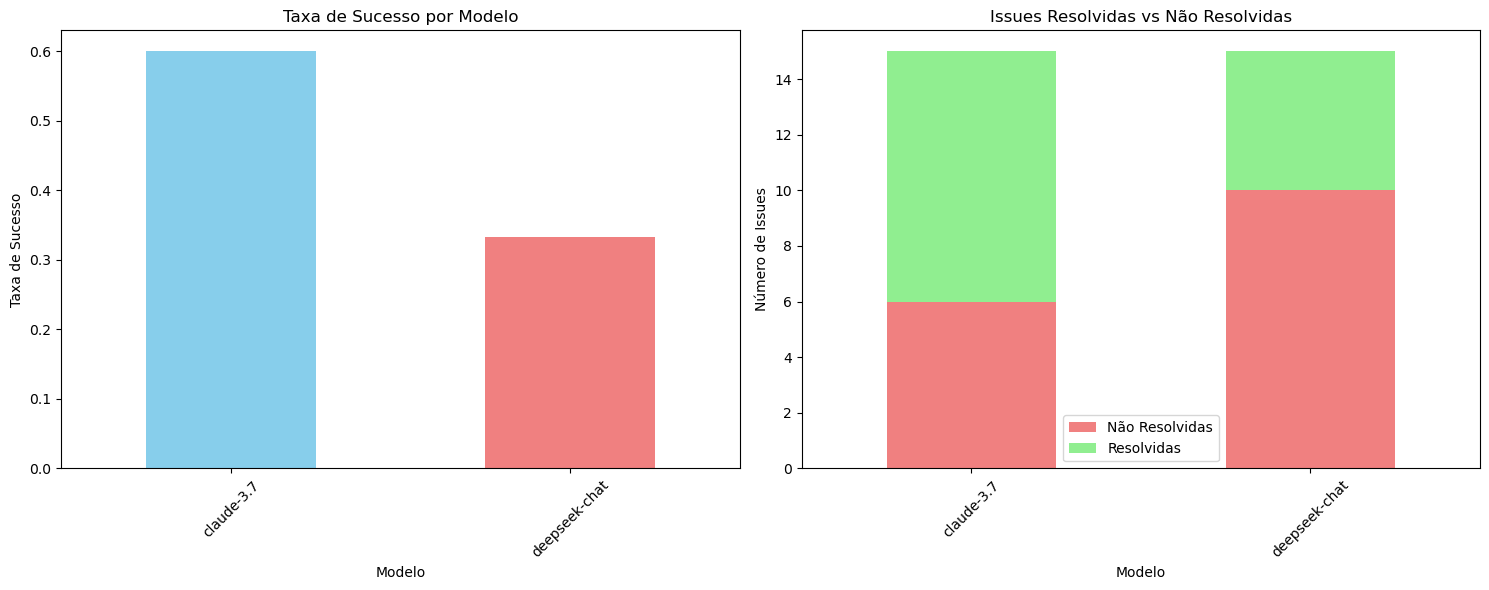

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Taxa de sucesso
success_rate['Taxa_Sucesso'].plot(kind='bar', ax=ax1, color=['skyblue', 'lightcoral'])
ax1.set_title('Taxa de Sucesso por Modelo')
ax1.set_ylabel('Taxa de Sucesso')
ax1.set_xlabel('Modelo')
ax1.tick_params(axis='x', rotation=45)

# Issues resolvidas vs não resolvidas
solved_counts = df.groupby(['model', 'solved']).size().unstack(fill_value=0)
solved_counts.plot(kind='bar', stacked=True, ax=ax2, color=['lightcoral', 'lightgreen'])
ax2.set_title('Issues Resolvidas vs Não Resolvidas')
ax2.set_ylabel('Número de Issues')
ax2.set_xlabel('Modelo')
ax2.legend(['Não Resolvidas', 'Resolvidas'])
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [7]:
cost_analysis = df.groupby('model').agg({
    'price': ['mean', 'sum', 'std'],
    'input_tokens': ['mean', 'sum'],
    'output_tokens': ['mean', 'sum'],
    'num_requests': ['mean', 'sum']
}).round(3)

print("\nAnálise de custos por modelo:")
print(cost_analysis)


Análise de custos por modelo:
               price                input_tokens            output_tokens  \
                mean     sum    std         mean        sum          mean   
model                                                                       
claude-3.7     0.867  13.011  0.986   639626.667  9594400.0      3863.467   
deepseek-chat  0.052   0.773  0.037   137460.000  2061900.0      1016.400   

                       num_requests         
                   sum         mean    sum  
model                                       
claude-3.7     57952.0       12.333  185.0  
deepseek-chat  15246.0        4.133   62.0  


In [8]:
# Custo por issue resolvida
cost_per_solved = df[df['solved'] == 1].groupby('model')['price'].mean()
print(f"\nCusto médio por issue resolvida:")
for model, cost in cost_per_solved.items():
    print(f"{model}: ${cost:.4f}")


Custo médio por issue resolvida:
claude-3.7: $0.5572
deepseek-chat: $0.0510


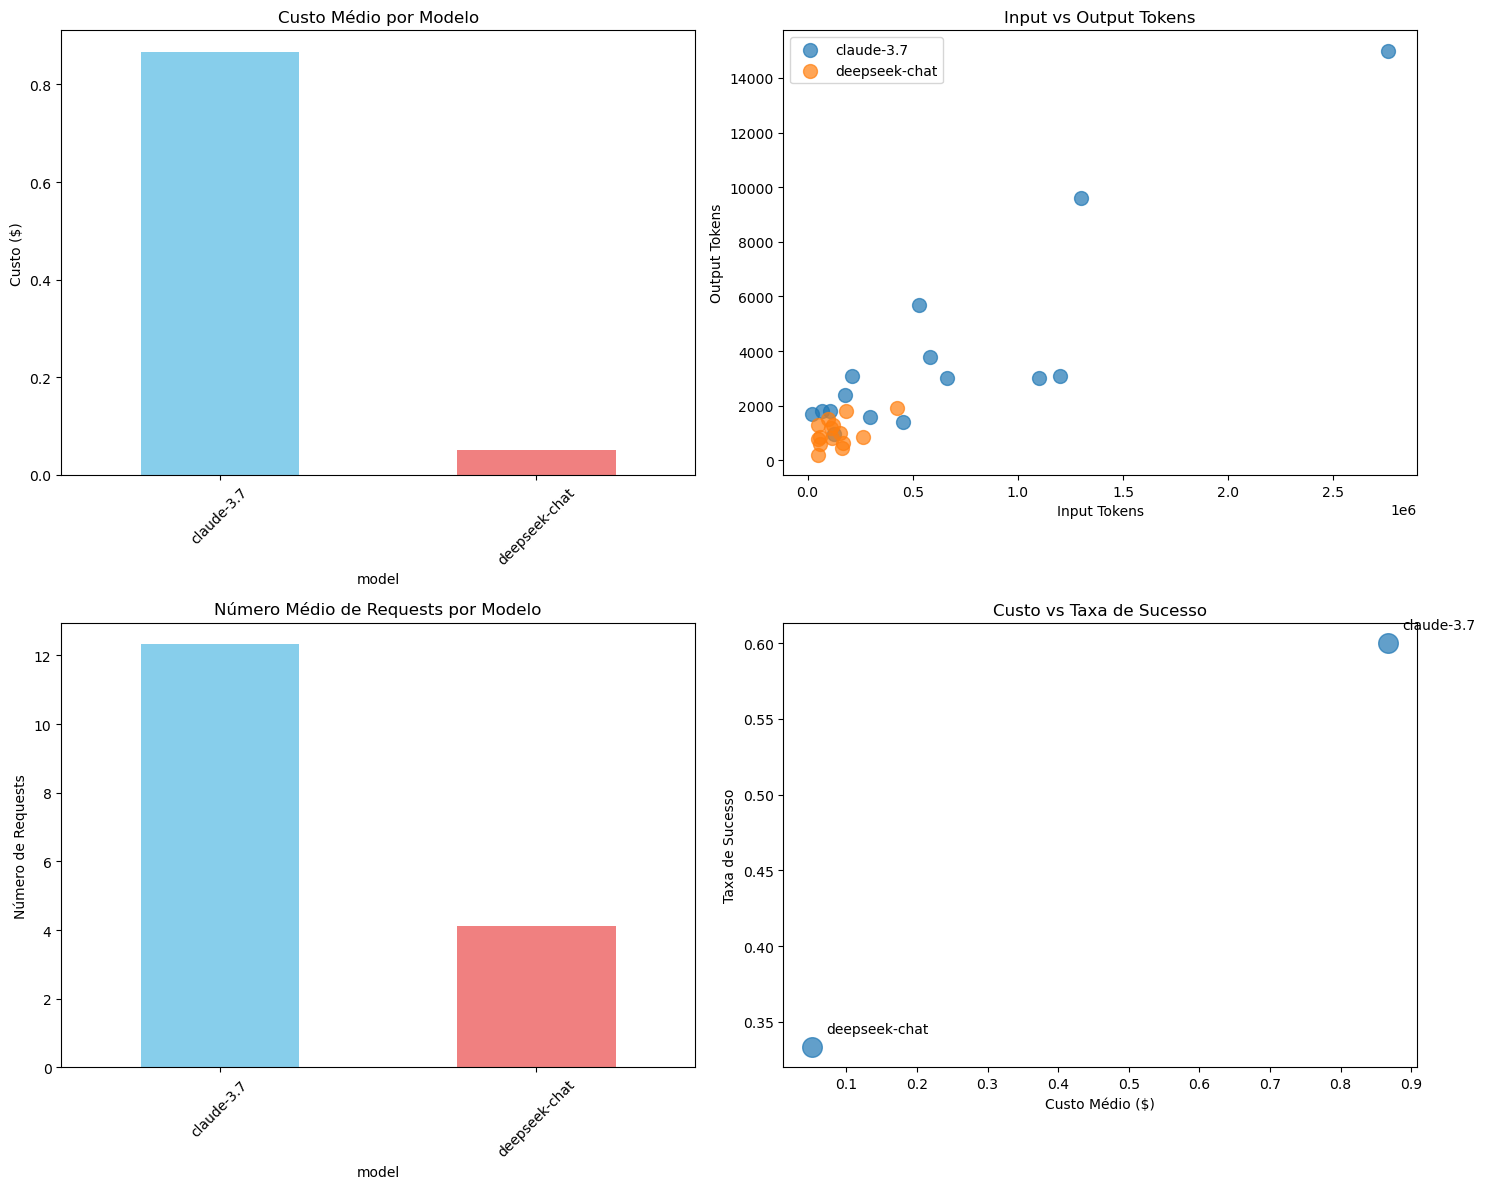

In [9]:
# Gráficos de custo
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Custo médio por modelo
df.groupby('model')['price'].mean().plot(kind='bar', ax=ax1, color=['skyblue', 'lightcoral'])
ax1.set_title('Custo Médio por Modelo')
ax1.set_ylabel('Custo ($)')
ax1.tick_params(axis='x', rotation=45)

# Tokens de entrada vs saída
models = df['model'].unique()
for model in models:
    model_data = df[df['model'] == model]
    ax2.scatter(model_data['input_tokens'], model_data['output_tokens'], 
               label=model, alpha=0.7, s=100)
ax2.set_xlabel('Input Tokens')
ax2.set_ylabel('Output Tokens')
ax2.set_title('Input vs Output Tokens')
ax2.legend()

# Número de requests por modelo
df.groupby('model')['num_requests'].mean().plot(kind='bar', ax=ax3, color=['skyblue', 'lightcoral'])
ax3.set_title('Número Médio de Requests por Modelo')
ax3.set_ylabel('Número de Requests')
ax3.tick_params(axis='x', rotation=45)

# Relação custo vs taxa de sucesso
model_stats = df.groupby('model').agg({
    'price': 'mean',
    'solved': 'mean'
}).reset_index()

ax4.scatter(model_stats['price'], model_stats['solved'], s=200, alpha=0.7)
for i, model in enumerate(model_stats['model']):
    ax4.annotate(model, (model_stats['price'].iloc[i], model_stats['solved'].iloc[i]),
                xytext=(10, 10), textcoords='offset points')
ax4.set_xlabel('Custo Médio ($)')
ax4.set_ylabel('Taxa de Sucesso')
ax4.set_title('Custo vs Taxa de Sucesso')

plt.tight_layout()
plt.show()

In [10]:
# Análise das mudanças no código
code_changes = df.groupby('model').agg({
    'total_changes': ['mean', 'std'],
    'files_changed': ['mean', 'std'],
    'additions': ['mean', 'std'],
    'deletions': ['mean', 'std']
}).round(2)

print("\nAnálise de mudanças no código:")
print(code_changes)


Análise de mudanças no código:
              total_changes         files_changed       additions         \
                       mean     std          mean   std      mean    std   
model                                                                      
claude-3.7            59.27  191.05          1.13  0.35       8.6  11.82   
deepseek-chat         11.53   16.69          1.13  0.35       8.8  12.07   

              deletions          
                   mean     std  
model                            
claude-3.7        50.67  189.89  
deepseek-chat      2.73    6.25  


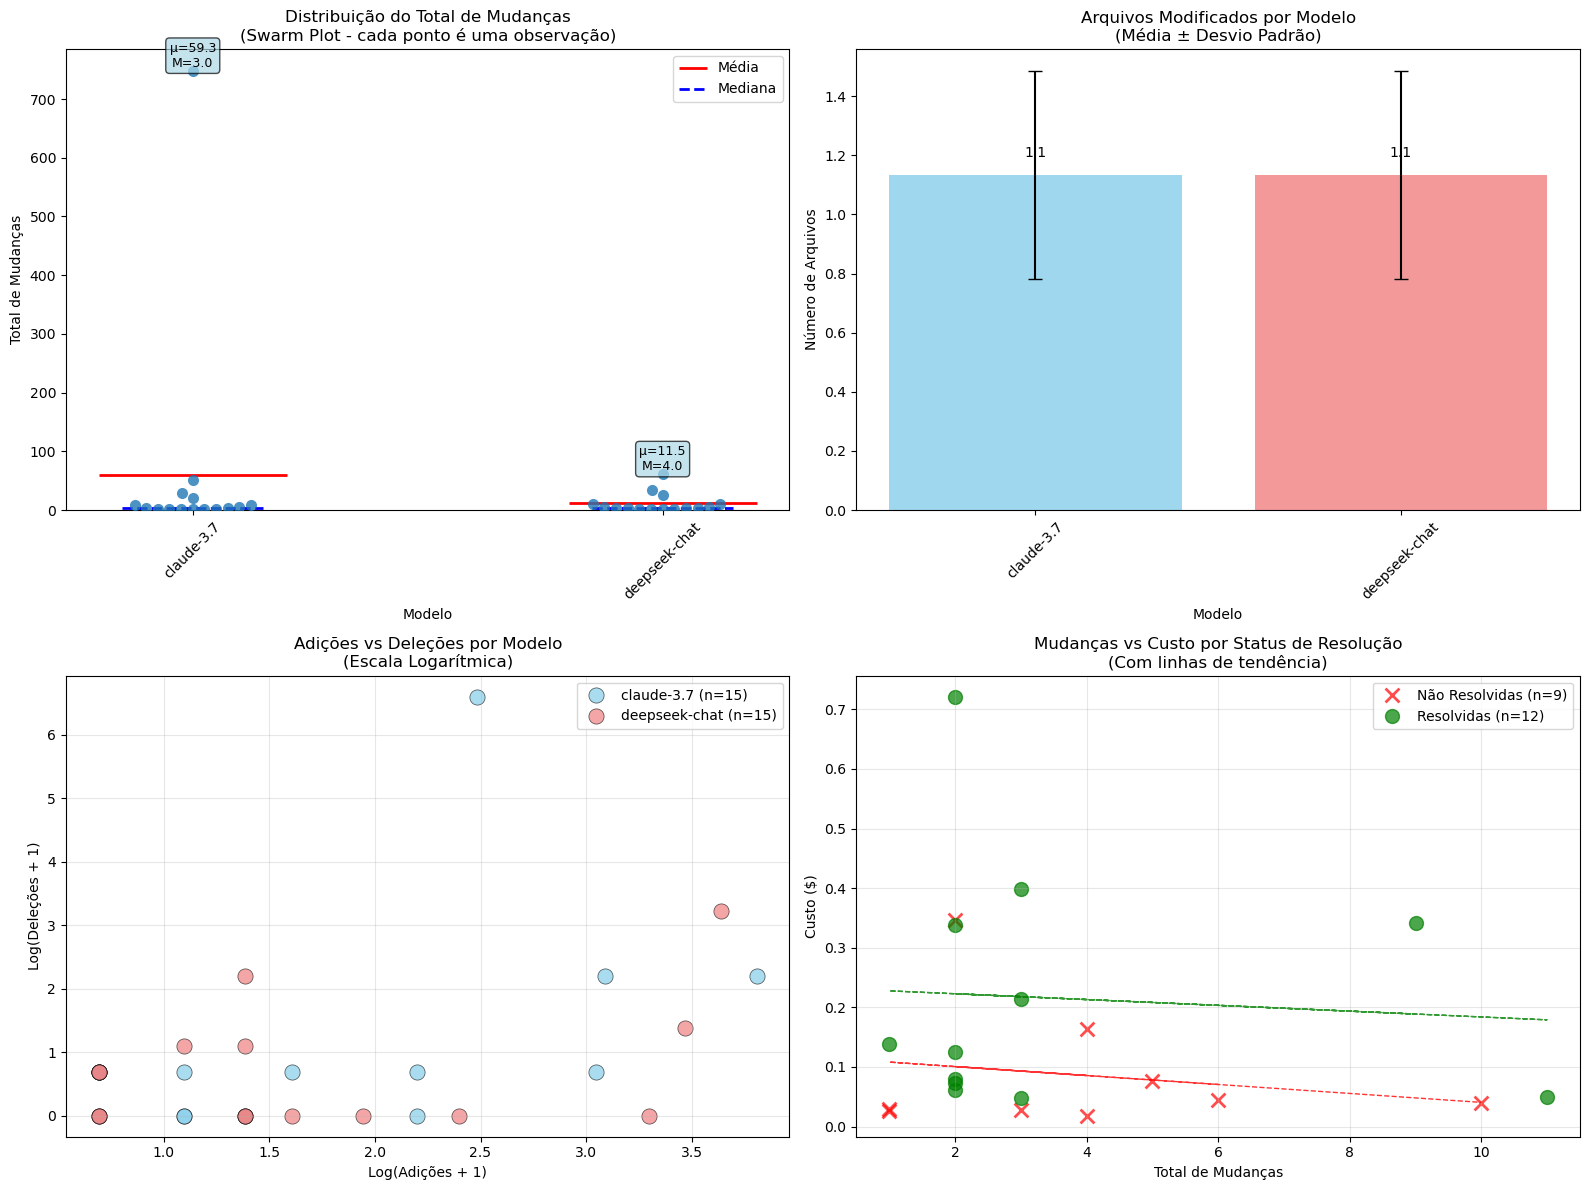

In [20]:
def remove_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Gráficos de mudanças no código (versão melhorada)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Swarm plot em vez de violin plot (melhor para poucos dados)
sns.swarmplot(data=df, x='model', y='total_changes', ax=ax1, size=8, alpha=0.8)
ax1.set_title('Distribuição do Total de Mudanças\n(Swarm Plot - cada ponto é uma observação)')
ax1.set_xlabel('Modelo')
ax1.set_ylabel('Total de Mudanças')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylim(bottom=0)  # Forçar que o eixo Y comece em 0

# Adicionar valores médios e medianos
for i, model in enumerate(df['model'].unique()):
    model_data = df[df['model'] == model]['total_changes']
    mean_val = model_data.mean()
    median_val = model_data.median()
    
    # Linha horizontal para a média
    ax1.hlines(mean_val, i-0.2, i+0.2, colors='red', linestyles='solid', linewidth=2, label='Média' if i == 0 else "")
    # Linha horizontal para a mediana
    ax1.hlines(median_val, i-0.15, i+0.15, colors='blue', linestyles='dashed', linewidth=2, label='Mediana' if i == 0 else "")
    
    # Texto com valores
    ax1.text(i, max(model_data) + 2, f'μ={mean_val:.1f}\nM={median_val:.1f}', 
             ha='center', va='bottom', fontsize=9,
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7))

if len(df['model'].unique()) <= 2:  # Só mostrar legenda se não ficar muito poluído
    ax1.legend(loc='upper right')

# 2. Bar plot para arquivos modificados (melhor para dados categóricos)
files_changed_mean = df.groupby('model')['files_changed'].agg(['mean', 'std']).reset_index()
bars = ax2.bar(files_changed_mean['model'], files_changed_mean['mean'], 
               yerr=files_changed_mean['std'], capsize=5, 
               color=['skyblue', 'lightcoral'], alpha=0.8)
ax2.set_title('Arquivos Modificados por Modelo\n(Média ± Desvio Padrão)')
ax2.set_xlabel('Modelo')
ax2.set_ylabel('Número de Arquivos')
ax2.tick_params(axis='x', rotation=45)

# Adicionar valores nas barras
for bar, val in zip(bars, files_changed_mean['mean']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{val:.1f}', ha='center', va='bottom')

# 3. Adições vs Deleções com escala log para lidar com outliers
models = df['model'].unique()
colors_map = {'claude-3.7': 'skyblue', 'deepseek-chat': 'lightcoral'}

for model in models:
    model_data = df[df['model'] == model]
    # Adicionar 1 para evitar log(0)
    additions_log = np.log1p(model_data['additions'])
    deletions_log = np.log1p(model_data['deletions'])
    
    ax3.scatter(additions_log, deletions_log, 
               label=f'{model} (n={len(model_data)})', 
               alpha=0.7, s=120, color=colors_map.get(model, 'gray'),
               edgecolors='black', linewidth=0.5)

ax3.set_xlabel('Log(Adições + 1)')
ax3.set_ylabel('Log(Deleções + 1)')
ax3.set_title('Adições vs Deleções por Modelo\n(Escala Logarítmica)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Mudanças vs Custo com categorização por sucesso e percentis
# Remover outliers extremos para melhor visualização
df_clean = df.copy()
for col in ['total_changes', 'price']:
    df_clean = remove_outliers(df_clean, col)

# Separar por status de resolução
solved_data = df_clean[df_clean['solved'] == 1]
unsolved_data = df_clean[df_clean['solved'] == 0]

# Plot com diferentes símbolos
ax4.scatter(unsolved_data['total_changes'], unsolved_data['price'], 
           c='red', alpha=0.7, s=100, marker='x', linewidth=2,
           label=f'Não Resolvidas (n={len(unsolved_data)})')
ax4.scatter(solved_data['total_changes'], solved_data['price'], 
           c='green', alpha=0.7, s=100, marker='o',
           label=f'Resolvidas (n={len(solved_data)})')

# Adicionar linhas de tendência
if len(unsolved_data) > 1:
    z_unsolved = np.polyfit(unsolved_data['total_changes'], unsolved_data['price'], 1)
    p_unsolved = np.poly1d(z_unsolved)
    ax4.plot(unsolved_data['total_changes'], p_unsolved(unsolved_data['total_changes']), 
             "r--", alpha=0.8, linewidth=1)

if len(solved_data) > 1:
    z_solved = np.polyfit(solved_data['total_changes'], solved_data['price'], 1)
    p_solved = np.poly1d(z_solved)
    ax4.plot(solved_data['total_changes'], p_solved(solved_data['total_changes']), 
             "g--", alpha=0.8, linewidth=1)

ax4.set_xlabel('Total de Mudanças')
ax4.set_ylabel('Custo ($)')
ax4.set_title('Mudanças vs Custo por Status de Resolução\n(Com linhas de tendência)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
# Análise adicional: Estatísticas resumidas sem outliers
print("\nEstatísticas de mudanças no código (sem outliers extremos):")
print("-" * 60)

for model in df['model'].unique():
    model_data = df[df['model'] == model]
    model_clean = remove_outliers(model_data, 'total_changes')
    
    print(f"\n{model.upper()}:")
    print(f"  Total de mudanças: {model_clean['total_changes'].mean():.1f} ± {model_clean['total_changes'].std():.1f}")
    print(f"  Arquivos modificados: {model_clean['files_changed'].mean():.1f} ± {model_clean['files_changed'].std():.1f}")
    print(f"  Adições: {model_clean['additions'].mean():.1f} ± {model_clean['additions'].std():.1f}")
    print(f"  Deleções: {model_clean['deletions'].mean():.1f} ± {model_clean['deletions'].std():.1f}")
    print(f"  Amostras (após remoção de outliers): {len(model_clean)}/{len(model_data)}")



Estatísticas de mudanças no código (sem outliers extremos):
------------------------------------------------------------

CLAUDE-3.7:
  Total de mudanças: 6.8 ± 8.6
  Arquivos modificados: 1.1 ± 0.3
  Adições: 5.7 ± 7.0
  Deleções: 1.2 ± 2.1
  Amostras (após remoção de outliers): 13/15

DEEPSEEK-CHAT:
  Total de mudanças: 4.3 ± 3.3
  Arquivos modificados: 1.0 ± 0.0
  Adições: 3.2 ± 2.6
  Deleções: 1.2 ± 2.3
  Amostras (após remoção de outliers): 12/15


In [21]:
comparison_metrics = ['price', 'input_tokens', 'output_tokens', 'num_requests', 
                     'total_changes', 'solved']

print("\nComparação entre Claude-3.7 e DeepSeek-Chat:")
print("-" * 50)

for metric in comparison_metrics:
    claude_vals = df[df['model'] == 'claude-3.7'][metric]
    deepseek_vals = df[df['model'] == 'deepseek-chat'][metric]
    
    print(f"\n{metric.upper()}:")
    print(f"  Claude-3.7: {claude_vals.mean():.3f} ± {claude_vals.std():.3f}")
    print(f"  DeepSeek-Chat: {deepseek_vals.mean():.3f} ± {deepseek_vals.std():.3f}")
    
    # Teste estatístico (se tiver dados suficientes)
    if len(claude_vals) > 1 and len(deepseek_vals) > 1:
        stat, p_value = stats.mannwhitneyu(claude_vals, deepseek_vals, alternative='two-sided')
        print(f"  P-value (Mann-Whitney): {p_value:.4f}")


Comparação entre Claude-3.7 e DeepSeek-Chat:
--------------------------------------------------

PRICE:
  Claude-3.7: 0.867 ± 0.986
  DeepSeek-Chat: 0.052 ± 0.037
  P-value (Mann-Whitney): 0.0000

INPUT_TOKENS:
  Claude-3.7: 639626.667 ± 720920.555
  DeepSeek-Chat: 137460.000 ± 100328.424
  P-value (Mann-Whitney): 0.0062

OUTPUT_TOKENS:
  Claude-3.7: 3863.467 ± 3760.421
  DeepSeek-Chat: 1016.400 ± 480.991
  P-value (Mann-Whitney): 0.0001

NUM_REQUESTS:
  Claude-3.7: 12.333 ± 12.022
  DeepSeek-Chat: 4.133 ± 2.200
  P-value (Mann-Whitney): 0.0018

TOTAL_CHANGES:
  Claude-3.7: 59.267 ± 191.052
  DeepSeek-Chat: 11.533 ± 16.690
  P-value (Mann-Whitney): 0.8836

SOLVED:
  Claude-3.7: 0.600 ± 0.507
  DeepSeek-Chat: 0.333 ± 0.488
  P-value (Mann-Whitney): 0.1570


In [22]:
df['cost_per_token'] = df['price'] / (df['input_tokens'] + df['output_tokens'])
df['tokens_per_request'] = (df['input_tokens'] + df['output_tokens']) / df['num_requests']
df['changes_per_dollar'] = df['total_changes'] / df['price']

efficiency_metrics = df.groupby('model').agg({
    'cost_per_token': 'mean',
    'tokens_per_request': 'mean',
    'changes_per_dollar': 'mean'
}).round(6)

print("\nMétricas de eficiência:")
print(efficiency_metrics)


Métricas de eficiência:
               cost_per_token  tokens_per_request  changes_per_dollar
model                                                                
claude-3.7           0.000002        45365.183244           41.349581
deepseek-chat        0.000000        35193.953030          360.505535


In [23]:
# ROI (Return on Investment) - considerando issues resolvidas
roi_data = []
for model in df['model'].unique():
    model_data = df[df['model'] == model]
    total_cost = model_data['price'].sum()
    issues_solved = model_data['solved'].sum()
    roi = issues_solved / total_cost if total_cost > 0 else 0
    roi_data.append({'model': model, 'roi': roi})

roi_df = pd.DataFrame(roi_data)
print(f"\nROI (Issues Resolvidas por Dólar):")
for _, row in roi_df.iterrows():
    print(f"{row['model']}: {row['roi']:.3f} issues/$")


ROI (Issues Resolvidas por Dólar):
claude-3.7: 0.692 issues/$
deepseek-chat: 6.467 issues/$


In [24]:
best_success_rate = success_rate['Taxa_Sucesso'].idxmax()
best_cost_efficiency = roi_df.loc[roi_df['roi'].idxmax(), 'model']
lowest_avg_cost = df.groupby('model')['price'].mean().idxmin()

print(f"• Melhor taxa de sucesso: {best_success_rate} ({success_rate.loc[best_success_rate, 'Taxa_Sucesso']:.1%})")
print(f"• Melhor eficiência de custo: {best_cost_efficiency} ({roi_df.loc[roi_df['roi'].idxmax(), 'roi']:.3f} issues/$)")
print(f"• Menor custo médio: {lowest_avg_cost} (${df.groupby('model')['price'].mean().min():.4f})")


• Melhor taxa de sucesso: claude-3.7 (60.0%)
• Melhor eficiência de custo: deepseek-chat (6.467 issues/$)
• Menor custo médio: deepseek-chat ($0.0515)
